<a href="https://colab.research.google.com/github/akrammakni/Fast-Food-Dataset-Classification/blob/main/ExamenTP_DL_AkramMakni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define constants

In [ ]:

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50


# Download the dataset using kagglehub

In [ ]:
!pip install -q kaggle
from google.colab import files

# Upload your Kaggle API key (kaggle.json)
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d utkarshsaxenadn/fast-food-classification-dataset
!unzip fast-food-classification-dataset.zip -d fast-food-classification

'!pip install -q kaggle\nfrom google.colab import files\n\n# Upload your Kaggle API key (kaggle.json)\nfiles.upload()  \n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n\n# Download dataset\n!kaggle datasets download -d utkarshsaxenadn/fast-food-classification-dataset\n!unzip fast-food-classification-dataset.zip -d fast-food-classification'

In [ ]:

import kagglehub
print("Downloading Fast Food Classification dataset...")
path = kagglehub.dataset_download("utkarshsaxenadn/fast-food-classification-dataset")
print("Path to dataset files:", path)
# Path to the dataset
dataset_path = path

Path to dataset files: /kaggle/input/fast-food-classification-dataset


In [ ]:
try:
    import kagglehub
    print("Downloading Fast Food Classification dataset...")
    path = kagglehub.dataset_download("utkarshsaxenadn/fast-food-classification-dataset")
    print("Path to dataset files:", path)
    dataset_path = path
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("If you have already downloaded the dataset, please set the correct path below.")
    dataset_path = "./fast-food-classification"  # Update this path to your local dataset

# Validate dataset structure
print("\nValidating dataset structure...")
if os.path.exists(dataset_path):
    # Check if there are subdirectories in the dataset path
    subdirs = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    print(f"Found {len(subdirs)} directories in dataset path.")

    # If no directories found or only a few, check if there's another level
    if len(subdirs) < 5:  # Expecting more classes for a food dataset
        for subdir in subdirs:
            sub_path = os.path.join(dataset_path, subdir)
            sub_subdirs = [f for f in os.listdir(sub_path) if os.path.isdir(os.path.join(sub_path, f))]
            print(f"Found {len(sub_subdirs)} directories in {subdir}.")
            if len(sub_subdirs) > 5:  # If we find more directories here, update path
                dataset_path = sub_path
                print(f"Updated dataset path to: {dataset_path}")
                break

    # Get class names from the dataset directory
    class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    class_names = [c for c in class_names if not c.startswith('.')]
    print(f"Class names: {class_names}")
    print(f"Number of classes: {len(class_names)}")

    # Count total images
    total_images = 0
    for cls in class_names:
        cls_path = os.path.join(dataset_path, cls)
        images = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f)) and
                 (f.lower().endswith('.jpg') or f.lower().endswith('.jpeg') or f.lower().endswith('.png'))]
        total_images += len(images)
        print(f"Class {cls}: {len(images)} images")
    print(f"Total images in dataset: {total_images}")
else:
    print(f"Dataset path {dataset_path} does not exist!")

Path to dataset files: /kaggle/input/fast-food-classification-dataset

Validating dataset structure...
Found 1 directories in dataset path.
Found 4 directories in Fast Food Classification V2.
Class names: ['Fast Food Classification V2']
Number of classes: 1
Class Fast Food Classification V2: 0 images
Total images in dataset: 0


In [ ]:
def check_dataset_structure(path):
    """Recursively explore the dataset directory structure to find class folders"""
    print(f"Exploring path: {path}")

    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return None

    # Check if this path contains image files directly
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and
             f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if files:
        print(f"Found {len(files)} image files directly in {path}")

    # Check subdirectories
    subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    if not subdirs:
        print(f"No subdirectories found in {path}")
        return None

    print(f"Found {len(subdirs)} subdirectories: {subdirs}")

    # Check if subdirectories contain images (potential class directories)
    potential_class_dirs = []
    for subdir in subdirs:
        subdir_path = os.path.join(path, subdir)
        subdir_files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f)) and
                       f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if subdir_files:
            print(f"  - {subdir}: {len(subdir_files)} images")
            potential_class_dirs.append(subdir_path)
        else:
            # Recursively check this directory
            nested_results = check_dataset_structure(subdir_path)
            if nested_results:
                potential_class_dirs.extend(nested_results)

    return potential_class_dirs if potential_class_dirs else None

# Run this to find where the images actually are
print("Checking dataset structure...")
dataset_path = "./fast-food-classification"  # Starting with your default path
potential_paths = check_dataset_structure(dataset_path)

# If we found potential class directories, use the first one's parent as our dataset path
if potential_paths:
    # Get the parent directory of the first potential class directory
    dataset_path = os.path.dirname(potential_paths[0])
    print(f"\nUpdated dataset path to: {dataset_path}")

    # Identify class names from this directory
    class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Found {len(class_names)} classes: {class_names}")
else:
    print("Could not identify appropriate dataset structure. Please check the dataset path.")
    # You might need to manually set the path
    # dataset_path = "./path/to/your/dataset"

Checking dataset structure...
Exploring path: ./fast-food-classification
Found 1 subdirectories: ['Fast Food Classification V2']
Exploring path: ./fast-food-classification/Fast Food Classification V2
Found 4 subdirectories: ['TFRecords', 'Test', 'Train', 'Valid']
Exploring path: ./fast-food-classification/Fast Food Classification V2/TFRecords
Found 3 subdirectories: ['Test', 'Train', 'Valid']
Exploring path: ./fast-food-classification/Fast Food Classification V2/TFRecords/Test
No subdirectories found in ./fast-food-classification/Fast Food Classification V2/TFRecords/Test
Exploring path: ./fast-food-classification/Fast Food Classification V2/TFRecords/Train
No subdirectories found in ./fast-food-classification/Fast Food Classification V2/TFRecords/Train
Exploring path: ./fast-food-classification/Fast Food Classification V2/TFRecords/Valid
No subdirectories found in ./fast-food-classification/Fast Food Classification V2/TFRecords/Valid
Exploring path: ./fast-food-classification/Fast Foo

In [ ]:
# Create a proper train-validation-test split
from sklearn.model_selection import train_test_split
import shutil

def create_splits(base_path, output_dir="split_dataset", test_size=0.2, val_size=0.2):
    """Create train/val/test splits from the dataset"""
    print(f"Creating splits from base path: {base_path}")
    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")
    test_dir = os.path.join(output_dir, "test")

    # Get class names
    class_names = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    print(f"Found {len(class_names)} classes: {class_names}")

    # Create output directories
    for dir_path in [train_dir, val_dir, test_dir]:
        os.makedirs(dir_path, exist_ok=True)
        for class_name in class_names:
            os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)

    # Process each class
    for class_name in class_names:
        class_path = os.path.join(base_path, class_name)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and
                 f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        print(f"Class {class_name}: Found {len(images)} images")

        if len(images) == 0:
            print(f"Warning: No images found for class {class_name}!")
            continue

        # First split into train+val and test
        train_val, test = train_test_split(images, test_size=test_size, random_state=42)

        # Then split train_val into train and val
        train, val = train_test_split(train_val, test_size=val_size, random_state=42)

        print(f"  Split for {class_name}: {len(train)} train, {len(val)} val, {len(test)} test")

        # Copy files
        for img in train:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_dir, class_name, img)
            shutil.copy(src, dst)

        for img in val:
            src = os.path.join(class_path, img)
            dst = os.path.join(val_dir, class_name, img)
            shutil.copy(src, dst)

        for img in test:
            src = os.path.join(class_path, img)
            dst = os.path.join(test_dir, class_name, img)
            shutil.copy(src, dst)

    print("Dataset split completed!")

# Call the fixed create_splits function
# If you couldn't identify the dataset path automatically, you'll need to set it manually here
create_splits(dataset_path)
split_base = "split_dataset"
train_dir = os.path.join(split_base, "train")
val_dir = os.path.join(split_base, "val")
test_dir = os.path.join(split_base, "test")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base directory where splits are stored
split_base = "split_dataset"

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



Creating splits from base path: ./fast-food-classification/Fast Food Classification V2/Test
Found 10 classes: ['Pizza', 'Sandwich', 'Fries', 'Taco', 'Crispy Chicken', 'Donut', 'Baked Potato', 'Hot Dog', 'Taquito', 'Burger']
Class Pizza: Found 200 images
  Split for Pizza: 128 train, 32 val, 40 test
Class Sandwich: Found 200 images
  Split for Sandwich: 128 train, 32 val, 40 test
Class Fries: Found 100 images
  Split for Fries: 64 train, 16 val, 20 test
Class Taco: Found 100 images
  Split for Taco: 64 train, 16 val, 20 test
Class Crispy Chicken: Found 100 images
  Split for Crispy Chicken: 64 train, 16 val, 20 test
Class Donut: Found 200 images
  Split for Donut: 128 train, 32 val, 40 test
Class Baked Potato: Found 100 images
  Split for Baked Potato: 64 train, 16 val, 20 test
Class Hot Dog: Found 200 images
  Split for Hot Dog: 128 train, 32 val, 40 test
Class Taquito: Found 100 images
  Split for Taquito: 64 train, 16 val, 20 test
Class Burger: Found 200 images
  Split for Burger: 12

In [ ]:

# Helper function to plot training history
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='upper left')

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{title} - Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


# Function to evaluate model
def evaluate_model(model, test_generator, title):
    # Evaluate the model
    print(f"\nEvaluating {title}...")
    test_generator.reset()
    evaluation = model.evaluate(test_generator)
    print(f"{title} - Loss: {evaluation[0]:.4f}, Accuracy: {evaluation[1]:.4f}")

    # Get predictions - need to reset generator first
    test_generator.reset()
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes

    # Get the class indices from the generator
    class_indices = test_generator.class_indices
    # Invert the dictionary to map indices to class names
    class_names = {v: k for k, v in class_indices.items()}

    # Get the actual classes present in the test data
    present_classes = np.unique(true_classes)
    print(f"Classes present in test data: {[class_names[i] for i in present_classes]}")
    print(f"Number of classes in test data: {len(present_classes)}")

    # Create class names list for display
    class_labels = [class_names[i] for i in sorted(present_classes)]

    # Use present_classes for the classification report
    # This ensures we only use labels that actually exist in the test data
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes,
                              labels=sorted(present_classes),
                              target_names=class_labels))

    # Create confusion matrix - only for classes present in test data
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(true_classes, predicted_classes, labels=sorted(present_classes))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_labels,
              yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


# Partie 1: MLP sur le Fast Food Dataset

In [ ]:
# 1. Charger et prétraiter le dataset
print("\n===== PARTIE 1: MLP =====")
print("Chargement et prétraitement des données...")

# Data generators for MLP - we'll flatten the images for MLP input
# Data generators for MLP - we'll flatten the images for MLP input
train_datagen_mlp = ImageDataGenerator(rescale=1./255)
val_datagen_mlp = ImageDataGenerator(rescale=1./255)
test_datagen_mlp = ImageDataGenerator(rescale=1./255)

# Load data from the split directories
train_generator_mlp = train_datagen_mlp.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator_mlp = val_datagen_mlp.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_mlp = test_datagen_mlp.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


===== PARTIE 1: MLP =====
Chargement et prétraitement des données...
Found 960 images belonging to 11 classes.
Found 240 images belonging to 11 classes.
Found 300 images belonging to 11 classes.


In [ ]:



# 2. Implémenter un MLP avec au moins deux couches cachées
print("\nCréation du modèle MLP...")

# Get the correct number of classes from your data generator
num_classes = len(train_generator_mlp.class_indices)
print(f"Number of classes in the dataset: {num_classes}")


# Update your models to use the correct number of classes
mlp_model = Sequential([
    Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')  # This will now output 11 classes
])

mlp_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Création du modèle MLP...
Number of classes in the dataset: 11


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Entraînement du modèle MLP...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.1217 - loss: 129.3681 - val_accuracy: 0.1625 - val_loss: 22.8220
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.1247 - loss: 26.7920 - val_accuracy: 0.1958 - val_loss: 10.1956
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.1952 - loss: 11.7590 - val_accuracy: 0.2333 - val_loss: 7.8201
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.2047 - loss: 7.3284 - val_accuracy: 0.1917 - val_loss: 6.0497
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.2598 - loss: 5.2429 - val_accuracy: 0.1500 - val_loss: 5.4494


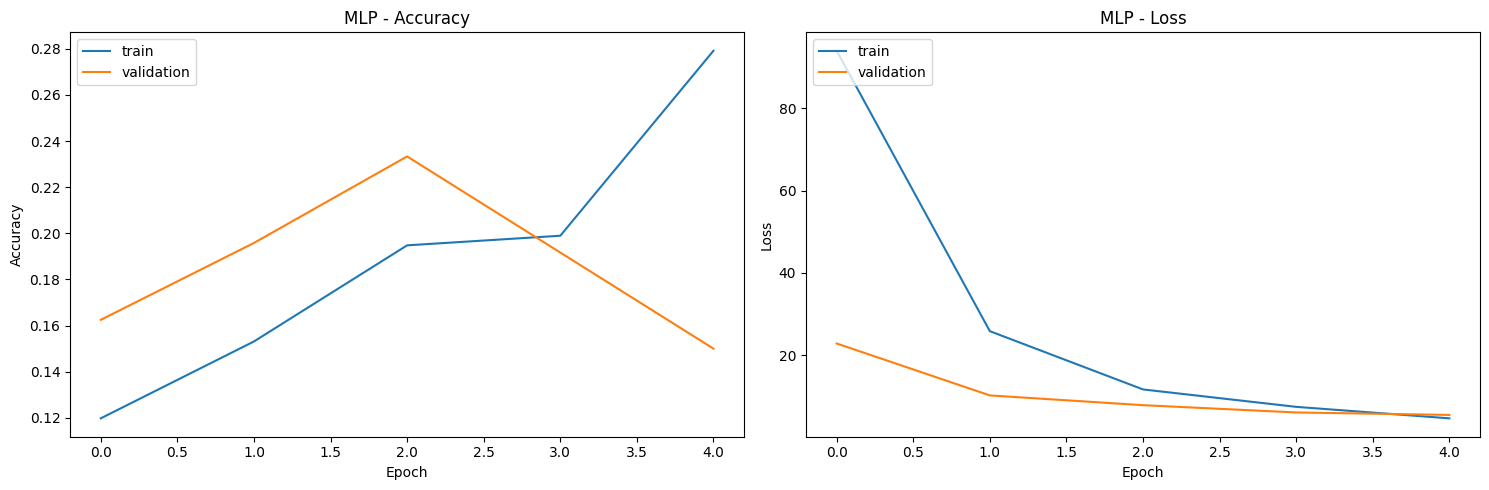

In [ ]:

# Train the model
print("\nEntraînement du modèle MLP...")
history_mlp = mlp_model.fit(
    train_generator_mlp,
    validation_data=validation_generator_mlp,
    epochs=5
)

# Visualize training results
plot_history(history_mlp, 'MLP')


In [ ]:

# 3. Détecter et corriger l'overfitting/underfitting
print("\nModification du MLP pour éviter l'overfitting...")

# Create an improved MLP with regularization techniques
mlp_improved = Sequential([
    Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Use the correct num_classes
])

mlp_improved.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp_improved.summary()

# Add callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)



Modification du MLP pour éviter l'overfitting...


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,205,003 (294.51 MB)

 Trainable params: 77,205,003 (294.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Train the improved MLP
print("\nEntraînement du modèle MLP amélioré...")
history_mlp_improved = mlp_improved.fit(
    train_generator_mlp,
    validation_data=validation_generator_mlp,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)




Entraînement du modèle MLP amélioré...
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.1243 - loss: 10.7199 - val_accuracy: 0.1542 - val_loss: 2.3736 - learning_rate: 1.0000e-04
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.1113 - loss: 2.3958 - val_accuracy: 0.1167 - val_loss: 2.3962 - learning_rate: 1.0000e-04
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.1208 - loss: 2.3981 - val_accuracy: 0.1375 - val_loss: 2.3935 - learning_rate: 1.0000e-04
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.1214 - loss: 2.3916 - val_accuracy: 0.1333 - val_loss: 2.3910 - learning_rate: 1.0000e-04
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.1369 - loss: 2.3909 - val_accuracy: 0.1333 - val_loss: 2.3904 - learning_rate: 2.0000e-05
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.1393 - loss: 2.3899 - val_accuracy: 0.1333 - val_loss: 2.3900 - learning_rate: 2.0000e-05


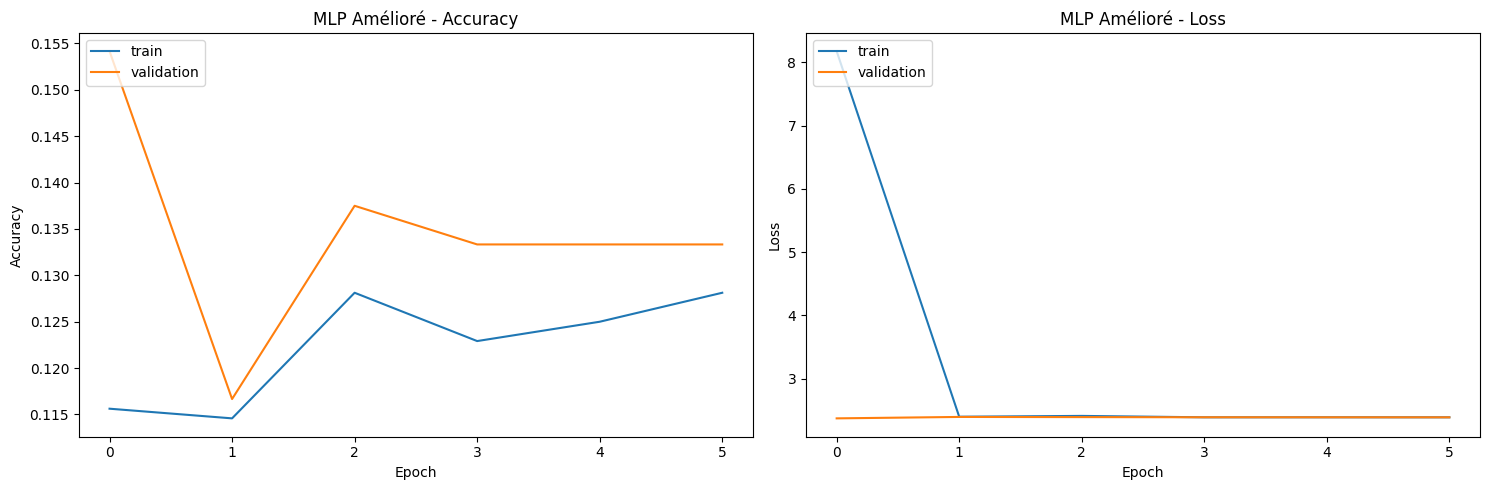


Evaluating MLP Amélioré...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1132 - loss: 2.3756
MLP Amélioré - Loss: 2.3751, Accuracy: 0.1400
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Classes present in test data: ['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']
Number of classes in test data: 10

Classification Report:
                precision    recall  f1-score   support

  Baked Potato       0.00      0.00      0.00        20
        Burger       0.00      0.00      0.00        40
Crispy Chicken       0.00      0.00      0.00        20
         Donut       0.67      0.15      0.24        40
         Fries       0.00      0.00      0.00        20
       Hot Dog       0.14      0.90      0.24        40
         Pizza       0.00      0.00      0.00        40
      Sandwich       0.00      0.00      0.00        40
          Taco       0.00      0.00      0.00        20
       Taquito       0.00      0.00      0.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


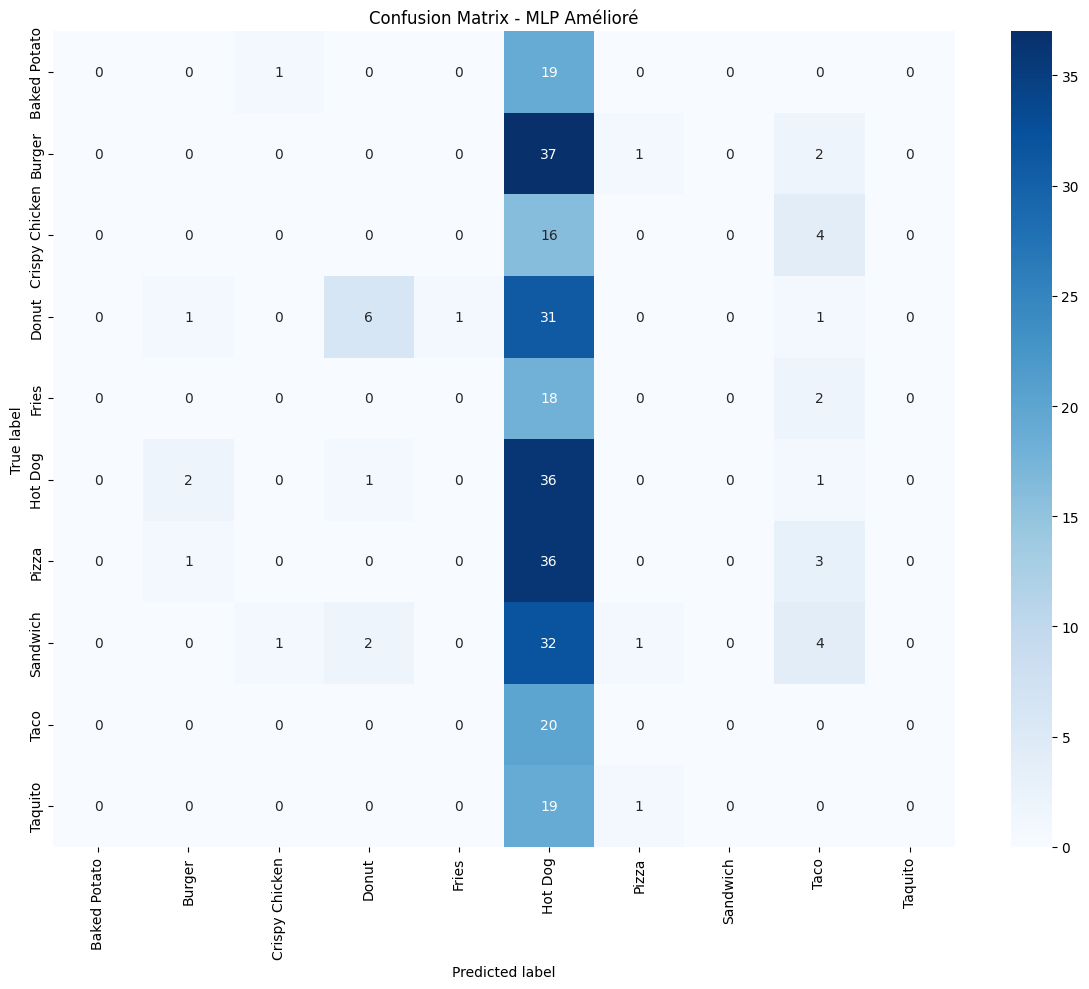

In [ ]:
# Visualize improved MLP results
plot_history(history_mlp_improved, 'MLP Amélioré')

# Evaluate the improved MLP
evaluate_model(mlp_improved, test_generator_mlp, 'MLP Amélioré')

# Partie 2: CNN sur le Fast Food Dataset

In [ ]:

# 1. Adapter la préparation des données pour un CNN
print("\n===== PARTIE 2: CNN =====")
print("Chargement et préparation des données pour CNN...")

# Data generators for CNN - we can use image augmentation here
train_datagen_cnn = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,

)
val_datagen_cnn = ImageDataGenerator(rescale=1./255)
test_datagen_cnn = ImageDataGenerator(rescale=1./255)

train_generator_cnn = train_datagen_cnn.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator_cnn = val_datagen_cnn.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# For evaluation
test_generator_cnn = test_datagen_cnn.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


===== PARTIE 2: CNN =====
Chargement et préparation des données pour CNN...
Found 960 images belonging to 11 classes.
Found 240 images belonging to 11 classes.
Found 300 images belonging to 11 classes.


In [ ]:

# 2. Implémenter un CNN simple
print("\nCréation du modèle CNN...")

cnn_model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and fully connected layers
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use the correct num_classes
])
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()



Création du modèle CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,786,443 (98.37 MB)

 Trainable params: 25,786,443 (98.37 MB)

 Non-trainable params: 0 (0.00 B)


Entraînement du modèle CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 439ms/step - accuracy: 0.1284 - loss: 3.6471 - val_accuracy: 0.1917 - val_loss: 2.2711
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.1606 - loss: 2.2654 - val_accuracy: 0.2125 - val_loss: 2.2041
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - accuracy: 0.1610 - loss: 2.2335 - val_accuracy: 0.2458 - val_loss: 2.1226
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.2648 - loss: 2.1095 - val_accuracy: 0.2292 - val_loss: 2.0662
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 414ms/step - accuracy: 0.2581 - loss: 2.0654 - val_accuracy: 0.2500 - val_loss: 2.0023
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.3016 - loss: 1.9762 - val_accuracy: 0.3042 - val_loss: 1.9155
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.3409 - loss: 1.8804 - val_accuracy: 0.3333 - val_loss: 1.8489
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 434ms/step - accuracy: 0.3184 - loss: 1.8667 - val_accu

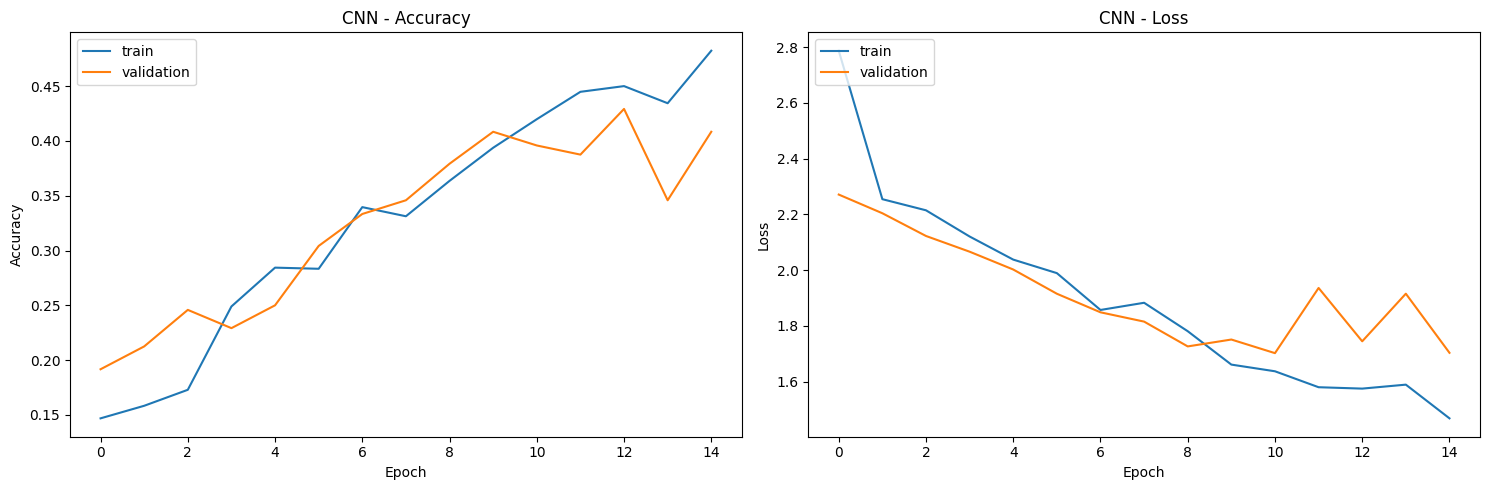

In [ ]:
# Train the CNN model
print("\nEntraînement du modèle CNN...")
history_cnn = cnn_model.fit(
    train_generator_cnn,
    validation_data=validation_generator_cnn,
    epochs=15
)

# Visualize CNN training results
plot_history(history_cnn, 'CNN')

In [ ]:



# 3. Appliquer des techniques pour améliorer la généralisation
print("\nCréation du modèle CNN amélioré avec techniques de régularisation...")

num_classes = len(train_generator_cnn.class_indices)
print(f"Number of classes in the dataset: {num_classes}")

# Fix the CNN improved model to use the correct number of classes
cnn_improved = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten and fully connected layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Use the correct num_classes
])

cnn_improved.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_improved.summary()


Création du modèle CNN amélioré avec techniques de régularisation...
Number of classes in the dataset: 11


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,787,339 (98.37 MB)

 Trainable params: 25,786,891 (98.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:

# Train the improved CNN model with callbacks
print("\nEntraînement du modèle CNN amélioré...")
history_cnn_improved = cnn_improved.fit(
    train_generator_cnn,
    validation_data=validation_generator_cnn,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)



Entraînement du modèle CNN amélioré...
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 444ms/step - accuracy: 0.1548 - loss: 6.3699 - val_accuracy: 0.0125 - val_loss: 7.3981 - learning_rate: 1.0000e-04
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 423ms/step - accuracy: 0.1444 - loss: 2.3533 - val_accuracy: 0.0292 - val_loss: 13.6899 - learning_rate: 1.0000e-04
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step - accuracy: 0.1321 - loss: 2.3339 - val_accuracy: 0.0667 - val_loss: 18.1872 - learning_rate: 1.0000e-04
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 415ms/step - accuracy: 0.1573 - loss: 2.2815 - val_accuracy: 0.0583 - val_loss: 20.2298 - learning_rate: 1.0000e-04
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 415ms/step - accuracy: 0.2168 - loss: 2.2126 - val_accuracy: 0.0583 - val_loss: 21.8441 - learning_rate: 2.0000e-05
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 407ms/step - accuracy: 0.1645 - loss: 2.2779 - val_accuracy: 0.0625 - val_loss: 22.5027 - learning_rate: 2.0000e-05


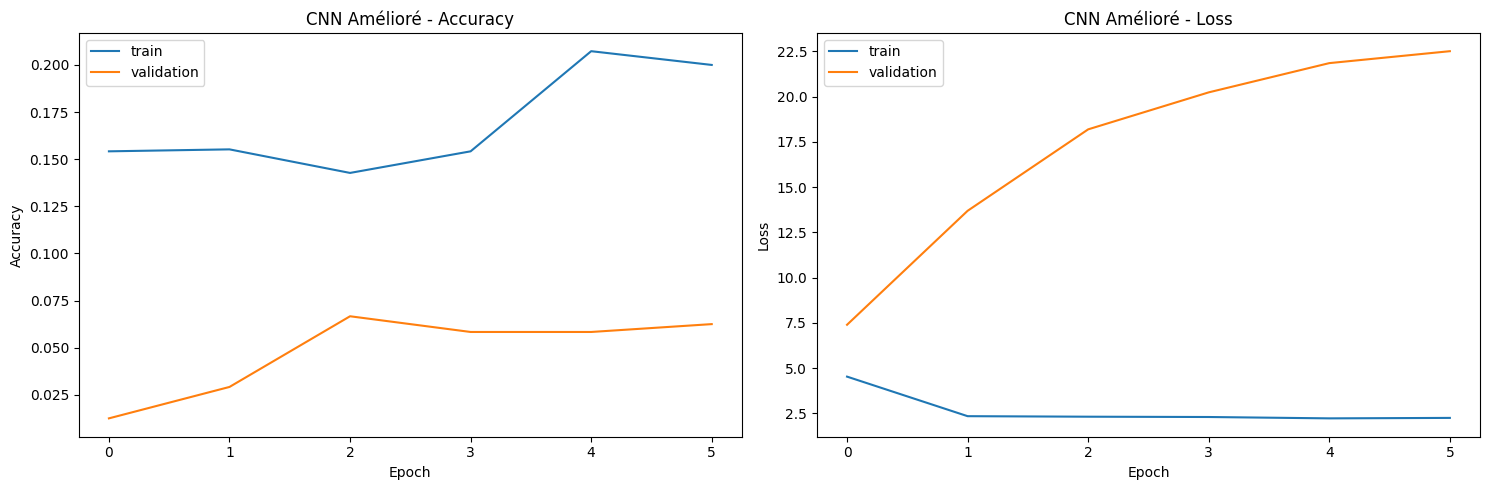


Evaluating CNN Amélioré...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0156 - loss: 7.8496
CNN Amélioré - Loss: 7.4240, Accuracy: 0.0133
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Classes present in test data: ['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']
Number of classes in test data: 10

Classification Report:
                precision    recall  f1-score   support

  Baked Potato       0.00      0.00      0.00        20
        Burger       0.00      0.00      0.00        40
Crispy Chicken       0.00      0.00      0.00        20
         Donut       0.80      0.10      0.18        40
         Fries       0.00      0.00      0.00        20
       Hot Dog       0.00      0.00      0.00        40
         Pizza       0.00      0.00      0.00        40
      Sandwich       0.00      0.00      0.00        40
          Taco       0.00      0.00      0.00        20
       Taquito       0.00      0.00      0.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


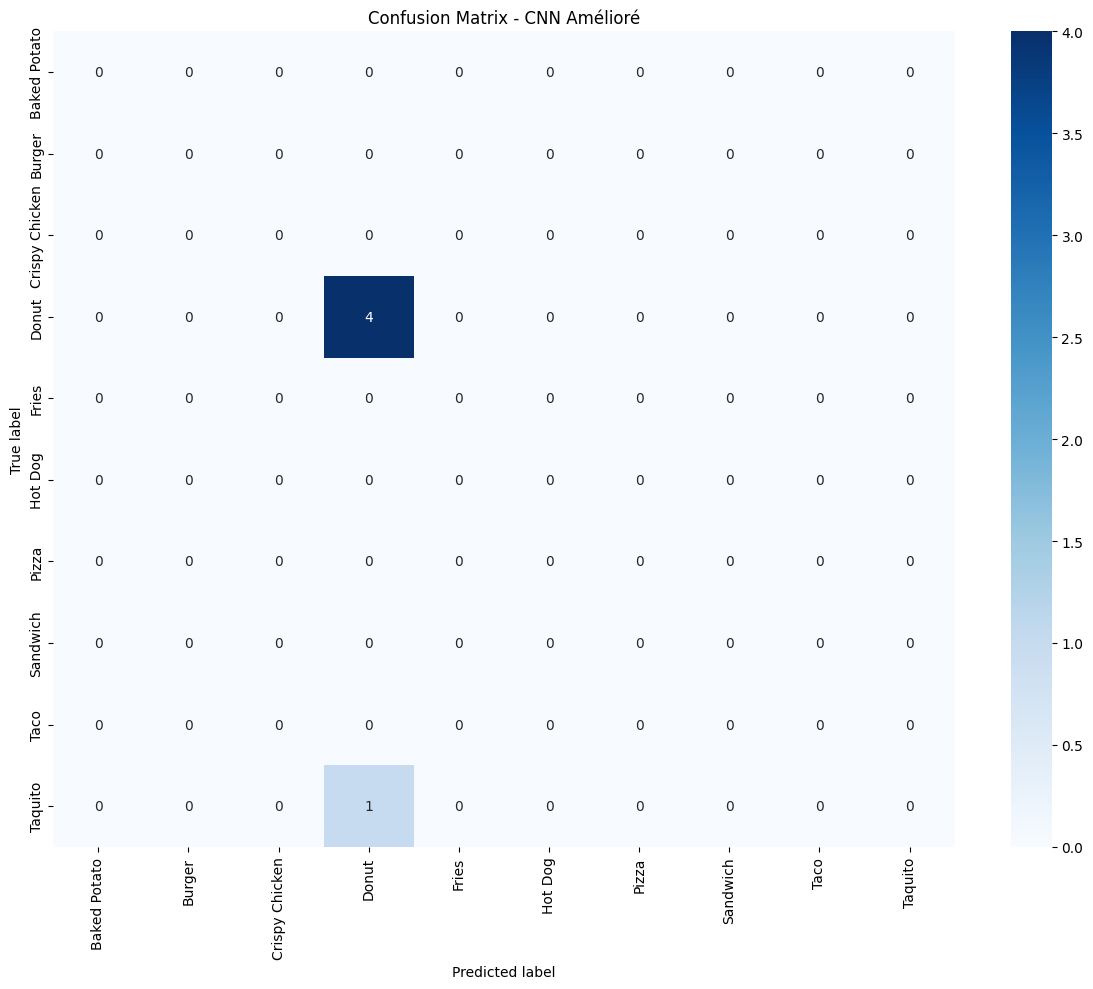

In [ ]:

# Visualize improved CNN results
plot_history(history_cnn_improved, 'CNN Amélioré')

# Evaluate the improved CNN
evaluate_model(cnn_improved, test_generator_cnn, 'CNN Amélioré')

# Partie 3: Transfer Learning

In [ ]:
# 1. Charger un modèle pré-entraîné
print("\n===== PARTIE 3: TRANSFER LEARNING =====")
print("Chargement du modèle pré-entraîné...")

# Use MobileNetV2 as the pre-trained model (smaller and faster than VGG16)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# 2. Utiliser la technique du transfer learning
print("\nCréation du modèle avec transfer learning (feature extraction)...")



===== PARTIE 3: TRANSFER LEARNING =====
Chargement du modèle pré-entraîné...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Création du modèle avec transfer learning (feature extraction)...


In [ ]:
# First approach: Feature extraction (freeze base model)
for layer in base_model.layers:
    layer.trainable = False

transfer_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Use the correct num_classes
])



transfer_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,317,387 (69.88 MB)

 Trainable params: 16,059,403 (61.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:


# Data preparation for transfer learning (using MobileNetV2 preprocessing)
train_datagen_tl = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen_tl = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_datagen_tl = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_generator_tl = train_datagen_tl.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
validation_generator_tl = val_datagen_tl.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_tl = test_datagen_tl.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 960 images belonging to 11 classes.
Found 240 images belonging to 11 classes.
Found 300 images belonging to 11 classes.



Entraînement du modèle avec transfer learning (feature extraction)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 681ms/step - accuracy: 0.2734 - loss: 3.3202 - val_accuracy: 0.6625 - val_loss: 1.0074 - learning_rate: 1.0000e-04
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 411ms/step - accuracy: 0.6108 - loss: 1.1482 - val_accuracy: 0.7083 - val_loss: 0.8498 - learning_rate: 1.0000e-04
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 416ms/step - accuracy: 0.7071 - loss: 0.9624 - val_accuracy: 0.7208 - val_loss: 0.7946 - learning_rate: 1.0000e-04
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 409ms/step - accuracy: 0.7569 - loss: 0.7801 - val_accuracy: 0.7708 - val_loss: 0.7107 - learning_rate: 1.0000e-04
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 410ms/step - accuracy: 0.7558 - loss: 0.7391 - val_accuracy: 0.7583 - val_loss: 0.7004 - learning_rate: 1.0000e-04
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 406ms/step - accuracy: 0.7974 - loss: 0.6307 - val_accuracy: 0.7583 - val_loss: 0.6946 - learning_rate: 1.0000e-04
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 407ms/step - acc

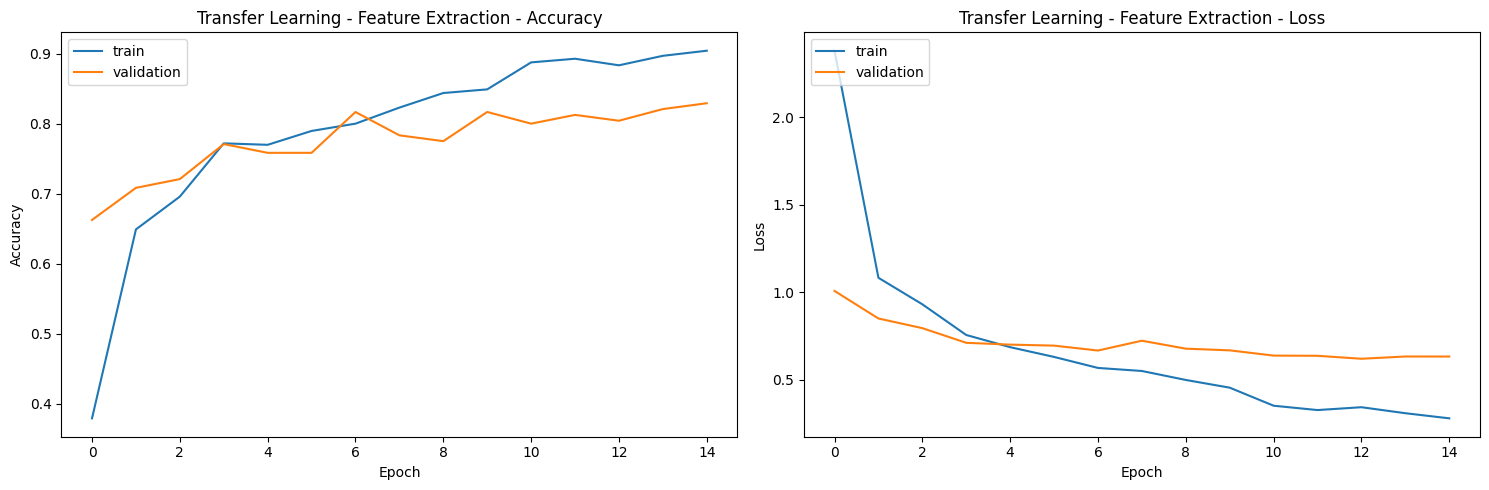

In [ ]:

# Train the transfer learning model
print("\nEntraînement du modèle avec transfer learning (feature extraction)...")
history_transfer = transfer_model.fit(
    train_generator_tl,
    validation_data=validation_generator_tl,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

# Visualize transfer learning results
plot_history(history_transfer, 'Transfer Learning - Feature Extraction')


In [ ]:
# 3. Fine-tuning - débloquer quelques couches
print("\nCréation du modèle avec fine-tuning partiel...")

# Second approach: Fine-tune the last few layers
base_model_ft = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze the bottom layers and unfreeze the top layers for fine-tuning
for layer in base_model_ft.layers[:-20]:  # Freeze all but the last 20 layers
    layer.trainable = False
for layer in base_model_ft.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

transfer_model_ft = Sequential([
    base_model_ft,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Use the correct num_classes
])

transfer_model_ft.compile(
    optimizer=Adam(learning_rate=0.00001),  # Use very low learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model_ft.summary()



Création du modèle avec fine-tuning partiel...


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,317,387 (69.88 MB)

 Trainable params: 17,265,483 (65.86 MB)

 Non-trainable params: 1,051,904 (4.01 MB)


Entraînement du modèle avec fine-tuning partiel...
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 684ms/step - accuracy: 0.1473 - loss: 3.6344 - val_accuracy: 0.2792 - val_loss: 2.1084 - learning_rate: 1.0000e-05
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - accuracy: 0.2775 - loss: 2.4455 - val_accuracy: 0.4208 - val_loss: 1.7322 - learning_rate: 1.0000e-05
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.3753 - loss: 1.9458 - val_accuracy: 0.5042 - val_loss: 1.5205 - learning_rate: 1.0000e-05
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.3914 - loss: 1.8015 - val_accuracy: 0.5792 - val_loss: 1.3656 - learning_rate: 1.0000e-05
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.4597 - loss: 1.5389 - val_accuracy: 0.6125 - val_loss: 1.2475 - learning_rate: 1.0000e-05
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 410ms/step - accuracy: 0.5292 - loss: 1.3891 - val_accuracy: 0.6333 - val_loss: 1.1385 - learning_rate: 1.0000e-05
Epoch 

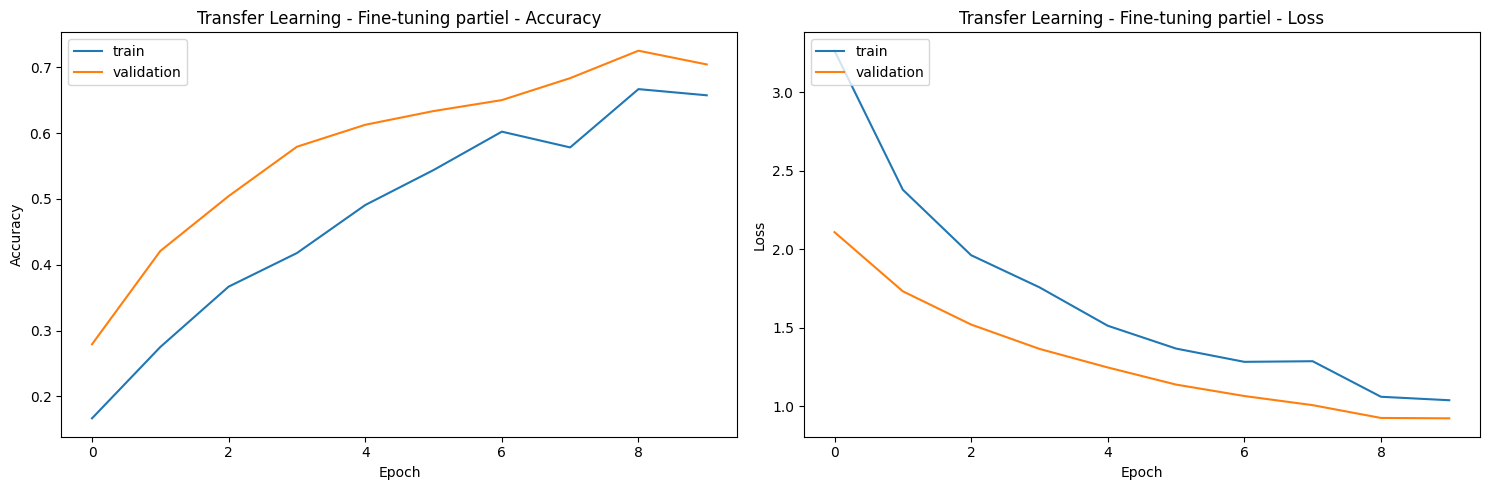

In [ ]:


# Train the fine-tuned model
print("\nEntraînement du modèle avec fine-tuning partiel...")
history_transfer_ft = transfer_model_ft.fit(
    train_generator_tl,
    validation_data=validation_generator_tl,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

# Visualize fine-tuning results
plot_history(history_transfer_ft, 'Transfer Learning - Fine-tuning partiel')


In [ ]:
# Fine-tuning complet
print("\nCréation du modèle avec fine-tuning complet...")

# Third approach: Fine-tune the entire model
base_model_full_ft = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Make all layers trainable
for layer in base_model_full_ft.layers:
    layer.trainable = True

transfer_model_full_ft = Sequential([
    base_model_full_ft,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Use the correct num_classes
])
transfer_model_full_ft.compile(
    optimizer=Adam(learning_rate=0.000005),  # Use even lower learning rate for full fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model_full_ft.summary()


Création du modèle avec fine-tuning complet...


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,317,387 (69.88 MB)

 Trainable params: 18,283,275 (69.75 MB)

 Non-trainable params: 34,112 (133.25 KB)


Entraînement du modèle avec fine-tuning complet...
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 65s 610ms/step - accuracy: 0.1074 - loss: 4.0379 - val_accuracy: 0.1708 - val_loss: 2.4010 - learning_rate: 5.0000e-06
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 438ms/step - accuracy: 0.1436 - loss: 3.1282 - val_accuracy: 0.2458 - val_loss: 2.1219 - learning_rate: 5.0000e-06
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 435ms/step - accuracy: 0.1978 - loss: 2.6625 - val_accuracy: 0.3208 - val_loss: 1.9367 - learning_rate: 5.0000e-06
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 435ms/step - accuracy: 0.2406 - loss: 2.3243 - val_accuracy: 0.4167 - val_loss: 1.7746 - learning_rate: 5.0000e-06
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 438ms/step - accuracy: 0.2834 - loss: 2.2588 - val_accuracy: 0.4417 - val_loss: 1.6635 - learning_rate: 5.0000e-06
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 438ms/step - accuracy: 0.3245 - loss: 2.0527 - val_accuracy: 0.4708 - val_loss: 1.5892 - learning_rate: 5.0000e-06
Epoch 

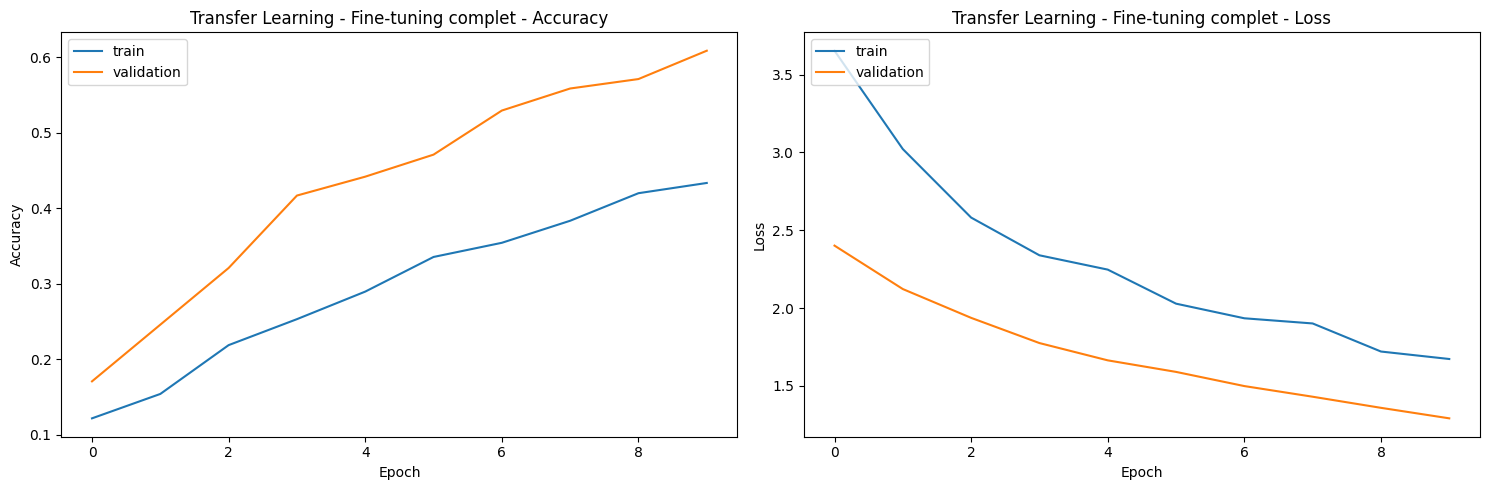


Evaluating Transfer Learning - Feature Extraction...
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step - accuracy: 0.8756 - loss: 0.3886
Transfer Learning - Feature Extraction - Loss: 0.4550, Accuracy: 0.8567
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step
Classes present in test data: ['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']
Number of classes in test data: 10

Classification Report:
                precision    recall  f1-score   support

  Baked Potato       1.00      0.85      0.92        20
        Burger       0.82      0.90      0.86        40
Crispy Chicken       0.95      0.90      0.92        20
         Donut       0.95      0.90      0.92        40
         Fries       0.95      0.90      0.92        20
       Hot Dog       0.81      0.75      0.78        40
         Pizza       0.84      0.93      0.88        40
      Sandwich       0.92      0.85      0.88        40
          Taco       0.70      0.70      0.70     

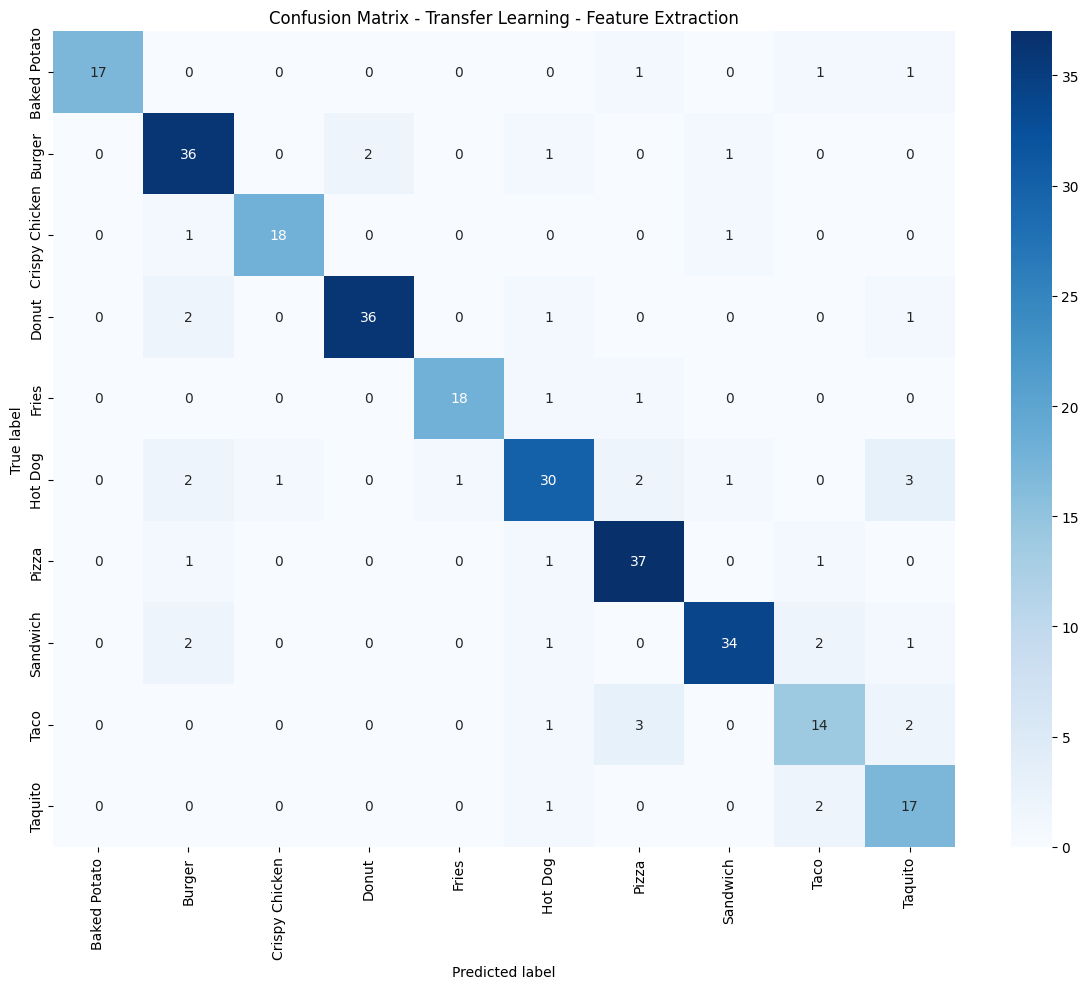


Evaluating Transfer Learning - Fine-tuning partiel...
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.7947 - loss: 0.7017
Transfer Learning - Fine-tuning partiel - Loss: 0.7830, Accuracy: 0.7533
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step
Classes present in test data: ['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']
Number of classes in test data: 10

Classification Report:
                precision    recall  f1-score   support

  Baked Potato       0.69      0.90      0.78        20
        Burger       0.87      0.85      0.86        40
Crispy Chicken       0.89      0.80      0.84        20
         Donut       0.97      0.80      0.88        40
         Fries       0.86      0.60      0.71        20
       Hot Dog       0.68      0.57      0.62        40
         Pizza       0.72      0.90      0.80        40
      Sandwich       0.68      0.75      0.71        40
          Taco       0.52      0.65      0.58   

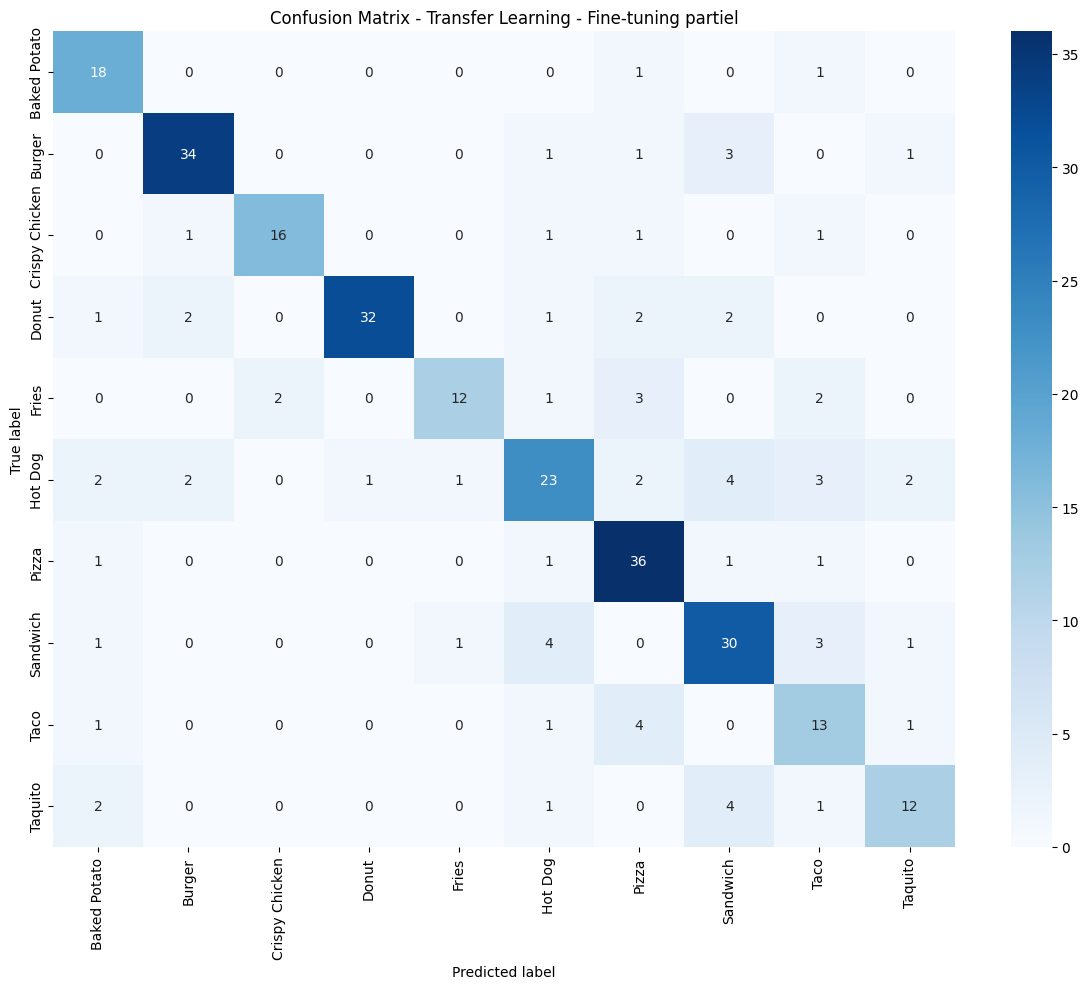


Evaluating Transfer Learning - Fine-tuning complet...
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.6213 - loss: 1.1493
Transfer Learning - Fine-tuning complet - Loss: 1.1915, Accuracy: 0.6100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step
Classes present in test data: ['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']
Number of classes in test data: 10

Classification Report:
                precision    recall  f1-score   support

  Baked Potato       0.57      0.40      0.47        20
        Burger       0.70      0.78      0.74        40
Crispy Chicken       0.67      0.80      0.73        20
         Donut       0.87      0.68      0.76        40
         Fries       0.67      0.30      0.41        20
       Hot Dog       0.49      0.45      0.47        40
         Pizza       0.50      0.93      0.65        40
      Sandwich       0.56      0.60      0.58        40
          Taco       0.46      0.30      0.36   

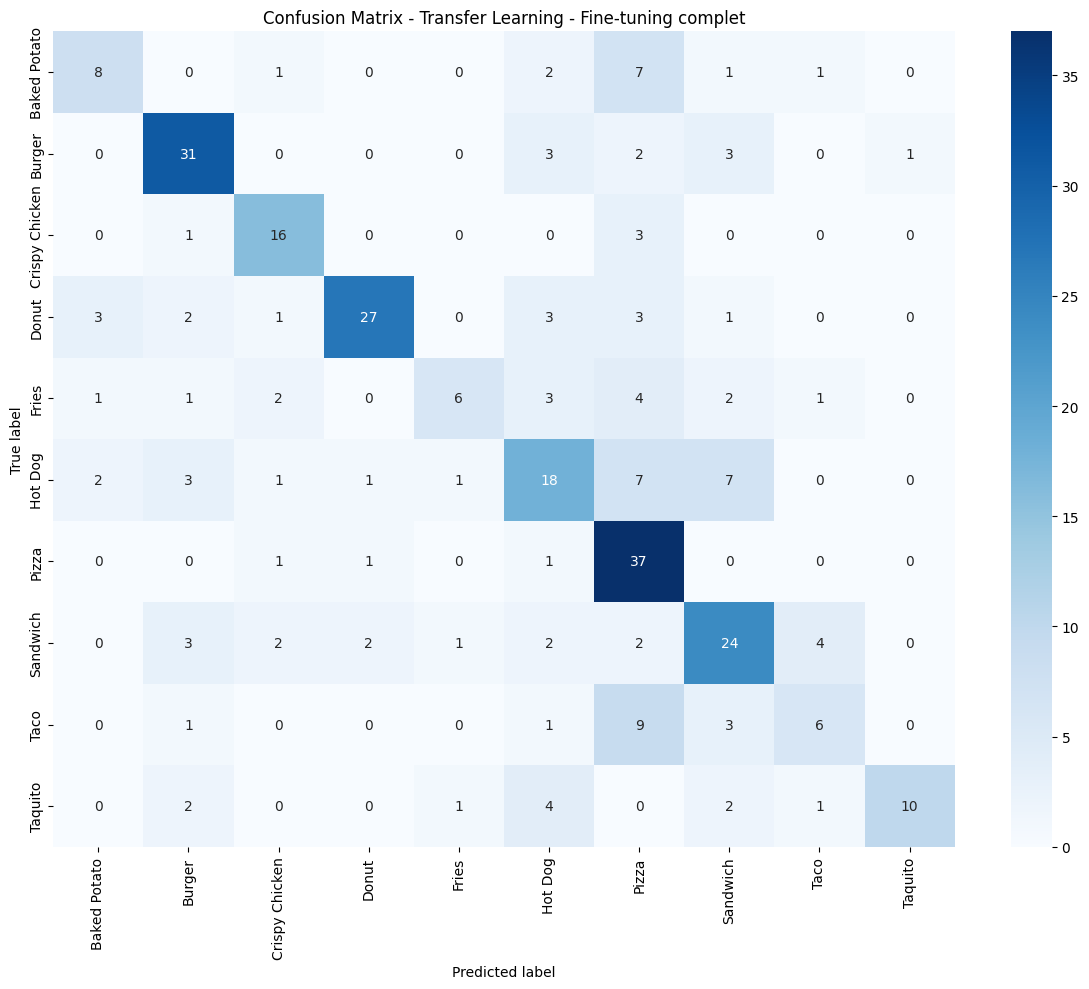

In [ ]:
# Train the fully fine-tuned model
print("\nEntraînement du modèle avec fine-tuning complet...")
history_transfer_full_ft = transfer_model_full_ft.fit(
    train_generator_tl,
    validation_data=validation_generator_tl,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

# Visualize full fine-tuning results
plot_history(history_transfer_full_ft, 'Transfer Learning - Fine-tuning complet')

# Evaluate the fine-tuned models
evaluate_model(transfer_model, test_generator_tl, 'Transfer Learning - Feature Extraction')
evaluate_model(transfer_model_ft, test_generator_tl, 'Transfer Learning - Fine-tuning partiel')
evaluate_model(transfer_model_full_ft, test_generator_tl, 'Transfer Learning - Fine-tuning complet')

# Partie 4: Comparaison des trois méthodes

In [ ]:
print("\n===== PARTIE 4: COMPARAISON DES TROIS MÉTHODES =====")

# Compare the best models from each approach
best_models = {
    'MLP': mlp_improved,
    'CNN': cnn_improved,
    'Transfer Learning (Feature Extraction)': transfer_model,
    'Transfer Learning (Fine-tuning partiel)': transfer_model_ft,
    'Transfer Learning (Fine-tuning complet)': transfer_model_full_ft
}

best_generators = {
    'MLP': test_generator_mlp,
    'CNN': test_generator_cnn,
    'Transfer Learning (Feature Extraction)': test_generator_tl,
    'Transfer Learning (Fine-tuning partiel)': test_generator_tl,
    'Transfer Learning (Fine-tuning complet)': test_generator_tl
}



===== PARTIE 4: COMPARAISON DES TROIS MÉTHODES =====


In [ ]:
# Compare model performances
results = []
for name, model in best_models.items():
    print(f"\nÉvaluation du modèle {name}...")
    evaluation = model.evaluate(best_generators[name])
    results.append({
        'Model': name,
        'Loss': evaluation[0],
        'Accuracy': evaluation[1]
    })

# Create a DataFrame to compare results
results_df = pd.DataFrame(results)
print("\nComparaison des performances des modèles:")
print(results_df)



Évaluation du modèle MLP...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1132 - loss: 2.3756

Évaluation du modèle CNN...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0156 - loss: 7.8496

Évaluation du modèle Transfer Learning (Feature Extraction)...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8756 - loss: 0.3886

Évaluation du modèle Transfer Learning (Fine-tuning partiel)...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7947 - loss: 0.7017

Évaluation du modèle Transfer Learning (Fine-tuning complet)...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6213 - loss: 1.1493

Comparaison des performances des modèles:
                                     Model      Loss  Accuracy
0                                      MLP  2.375094  0.140000
1                                      CNN  7.423978  0.013333
2   Transfer Learning (Feature Extraction)  0.455032  0.856667
3  Transfer Learning (Fine-tuning partiel)  0.783027  0.753333
4  Transfer Learning

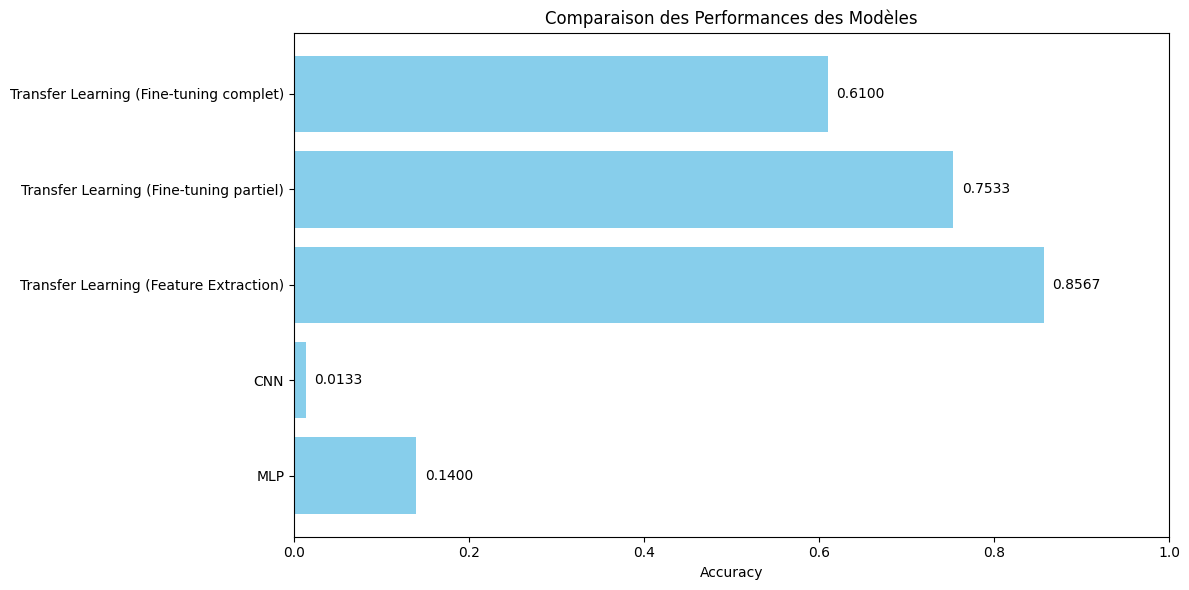

In [ ]:


# Visualize comparison
plt.figure(figsize=(12, 6))
plt.barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Comparaison des Performances des Modèles')
plt.xlim(0, 1)
for i, v in enumerate(results_df['Accuracy']):
    plt.text(v + 0.01, i, f"{v:.4f}", va='center')
plt.tight_layout()
plt.show()
